# Predicting Second Down

### The purpose of this notebook is to implement some machine learning algorithms to try and predict whether a team will run or pass on second down, using the 2015 NFL Play-By-Play dataset.

In [131]:
# First Let's import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn import preprocessing
%matplotlib inline

In [2]:
#Now we will read in the data grab the second down plays which resulted in a run or a pass

file_loc = "/home/matt/Downloads/nfl.csv"
data = pd.read_csv(file_loc)

second = data[(data['down'] == 2) & ((data['PlayType'] == 'Pass') | (data['PlayType'] == 'Run'))]

/home/matt/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Before running any algorithms, let's do some naive predictions.

In [3]:
breakdown = second['PlayType'].value_counts()
breakdown['Pass']/ (breakdown['Pass'] + breakdown['Run'])

0.58024926267719534

### This tells us that we can guess correctly 58% of the time just by always choosing pass. On the other hand, if it is second and short a run is more likely than a pass, as the following plots illustrate.

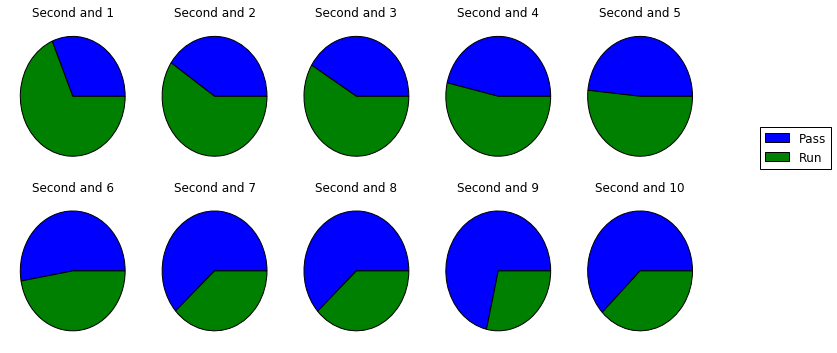

In [43]:
passing = second[second['PlayType'] == 'Pass']
running = second[second['PlayType'] == 'Run']

plt.figure(figsize = (10, 5))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.pie([second[second['ydstogo'] == i]['PlayType'].value_counts()['Pass'],
           second[second['ydstogo'] == i]['PlayType'].value_counts()['Run']])
    plt.title('Second and %i' %i)
    plt.tight_layout()
plt.legend(['Pass','Run'], bbox_to_anchor = (2, 1.5))

### As we can see, it is reasonable to predict run if it is second down with five or fewer yards to go, and pass otherwise. Let's see how good this simple strategy is.

In [53]:
second['Prediction'] = second['ydstogo'] <= 5
second['Ran'] = second['PlayType'] == 'Run'

check = second['Prediction'] == second['Ran']
check.mean()

/home/matt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/matt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


0.62553515364855861

### So we have a 63% chance of predicting correctly if we choose run when it is second down with five or fewer yards to go, and choose pass otherwise. Let's see if we can beat this by applying some common classification algorithms. First let's single out some columns which we believe will make the best predictors, and separate our data into training and testing subsets.

In [136]:
second['TimeInHalf'] = second['TimeSecs']%(60*30)
X = preprocessing.scale(second[['ydstogo', 'yrdline100', 'TimeInHalf', 'ScoreDiff']])
y = second['PlayType']

X_train = X[:round(.8*X.shape[0]):,]
y_train = y.iloc[:round(.8*y.shape[0])]

X_test = X[round(.8*X.shape[0]):,]
y_test = y.iloc[round(.8*y.shape[0]):]

/home/matt/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Now we will apply logistic regression, using the sklearn package.

In [137]:
logistic = LogisticRegression()

logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [139]:
check = logistic.predict(X_test) == y_test
check.mean()

0.6260704091341579

In [140]:
neighbors = KNeighborsClassifier(n_neighbors = 4)
neighbors.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='uniform')

In [141]:
check = neighbors.predict(X_test) == y_test
check.mean()

0.6060894386298763

In [142]:
support = svm.SVC()
support.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [125]:
check = support.predict(X_test) == y_test
check.mean()

0.56422454804947664

In [145]:
dectree = tree.DecisionTreeClassifier()
dectree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [146]:
check = dectree.predict(X_test) == y_test
check.mean()

0.57849666983824932

array([[-1.62454317,  0.00907153,  1.62658044,  0.10613311],
       [ 4.66969665, -0.43668275,  1.27406562,  0.10613311],
       [ 0.47353677, -0.39615964,  1.00460404,  0.10613311],
       ..., 
       [ 0.47353677,  1.1031957 , -1.3707183 ,  0.66146297],
       [ 0.47353677,  0.21168712, -1.49252971, -0.44919675],
       [-1.15830318, -0.55825211, -1.54789853, -0.44919675]])